# MPS for device simulation at different theta and L values

* In this notebook we will create and pickle the MPS 

* We will unpickle these MPS in another notebook and look at the $XX$ and $ZZ$ correaltion functions and entanglement entropy for various choices of the time parameter $\theta$


In [1]:
import numpy as np
import ast
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
from quimb import *
from quimb.tensor import *
import sympy as sym

from joblib import Parallel, delayed
import pandas as pd
import time

import scipy as sp
from scipy import linalg
import pickle

from JC_functions import *

/home/joesullivan/.local/lib/python3.8/site-packages/cotengra/hyperoptimizers/hyper.py:34: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [2]:
# We will be stroring these so don't refresh this cell
MPS_dictionary = {}
MPS_Motz_dictionary = {}

## Lets look at the hopping probabilities for 8 different values of $\theta$ 

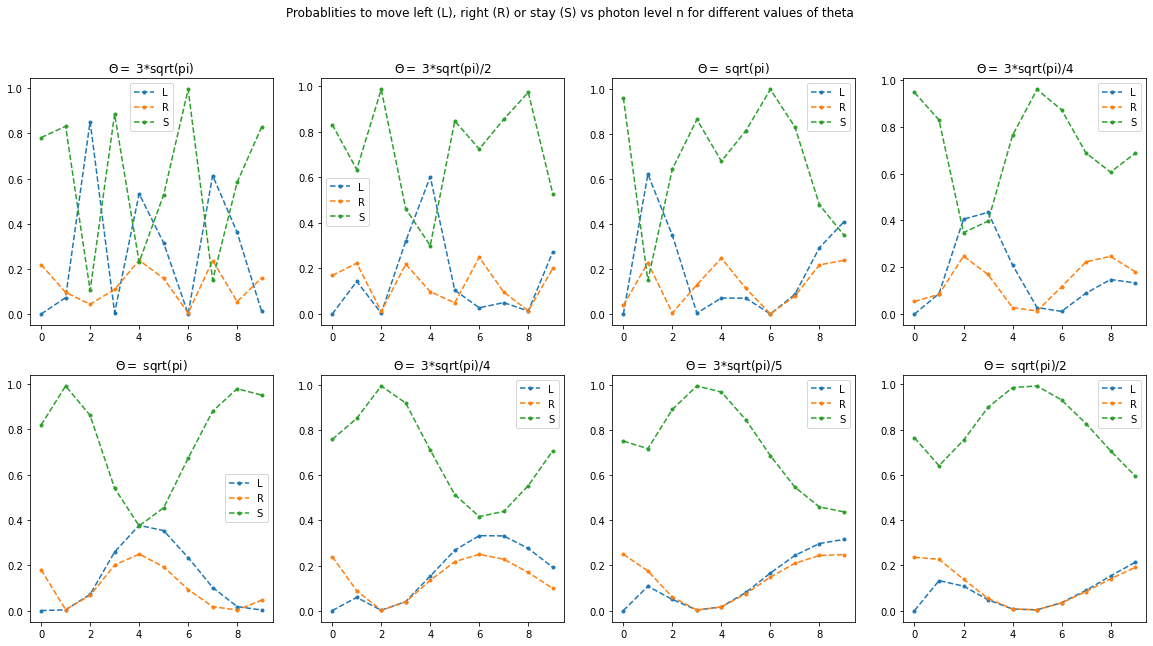

In [3]:
N= 10
theta_list = [3*np.sqrt(np.pi)/i for i in range(1,10)]
theta_sym_list = [sym.symbols(f'{3*sym.sqrt(sym.pi)/i}') for i in range(1,10)]


fig, axs = plt.subplots(2,4, figsize = (20,10))
for i in range(4):
    for j in range(2):
        L, S, R = [[], [],[]]
        for n in range(N):
            P = Hop_prob(n,theta_list[4*j + i])
            L.append(P[0])
            S.append(P[1])
            R.append(P[2])

        axs[j,i].plot(L, '--.', label = 'L')
        axs[j,i].plot(R, '--.', label = 'R')
        axs[j,i].plot(S, '--.', label = 'S')
        axs[j,i].set_title(f'$\Theta =$ {theta_sym_list[2*j+i]}')
        axs[j,i].legend()

fig.suptitle('Probablities to move left (L), right (R) or stay (S) vs photon level n for different values of theta')
plt.show()


# Now lets define some matrix product states:

## MPS for the choice of $\theta$ above

In [4]:
N_list = [10, 30, 100, 200, 800]

## Make list with JC MPS for all the theta and N

In [5]:
def make_MPS(dict_data):
    theta, N = dict_data
    chi = max(int(np.sqrt(N)), 15)
    
    A_JC = MPS_JC_2site(chi,theta)
    BL = np.zeros((2, chi, chi))
    BL[0,0,0] = 1

    MPS_list = [A_JC for i in range(N)]
    MPS_list.insert(0, BL)
    MPS_list.append(BL)

    JC_MPS = MatrixProductState(MPS_list, shape = 'plr')
    JC_MPS.cyclic = False
    JC_MPS.normalize()

    print(f'done with {dict_data}')

    return [dict_data,JC_MPS]

theta_N_list = [[theta, N] for theta in theta_list for N in N_list]

JC_list = Parallel(n_jobs=-1)(delayed(make_MPS)(data) for data in theta_N_list)

## Do same for Motzkin chain vs L

In [6]:
pL, pR = [.2,.2]

def make_Motz(N):
    chi = max(int(np.sqrt(N)), 20)
    A_Motz = MPS_Motzkin(chi, pL,pR)
    BL = np.zeros((2, chi, chi))
    BL[0,0,0] = 1

    MPS_list = [A_Motz for i in range(N)]
    MPS_list.insert(0, BL)
    MPS_list.append(BL)

    Motz_MPS = MatrixProductState(MPS_list, shape = 'plr')
    Motz_MPS.cyclic = False
    Motz_MPS.normalize()
    return [N, Motz_MPS]

Motz_list = Parallel(n_jobs=-1)(delayed(make_Motz)(N) for N in N_list)

## Lets convert these into dictionaries

In [7]:
for item in JC_list:
    MPS_dictionary[item[0][0], item[0][1]] = item[1]

for item in Motz_list:
    MPS_Motz_dictionary[item[0]] = item[1]

# Now lets pickle these dictionaries

In [8]:
with open('JC_MPS.pickle', 'wb') as file:
    pickle.dump(MPS_dictionary, file)

with open('Motz_MPS.pickle', 'wb') as file:
    pickle.dump(MPS_Motz_dictionary, file)


# Next we generate the correaltion function in terminal using parallel computing

* data stored in file

In [15]:
with open('JC_MPS.pickle', 'rb') as file:
    JC_MPS_dict = pickle.load(file)

### Define relevant operators for correlation fcn data

In [16]:
Z_A, Z_B = [np.kron(pauli('Z'), np.eye(2)), np.kron(np.eye(2),pauli('Z'))]
X_A, X_B = [np.kron(pauli('X'), np.eye(2)), np.kron(np.eye(2),pauli('X'))]


#for Motz
Zspin1 = pauli('Z', dim=3)
Xspin1 = pauli('X', dim=3)

## ZZ data:

In [17]:
def ZZ(stuff):
    data, x = stuff
    return np.real(JC_MPS_dict[data].correlation(Z_A+Z_B, 2,x))

theta = theta_list[0]

#first do ZZ data
for N in N_list:
    t1 = time.time()
    x_data = list(range(2,N,int(N/20)+1))
    stuff_list = [[(theta,N), x] for x in x_data]
    
    ZZ_result = Parallel(n_jobs=-1)(delayed(ZZ)(stuff) for stuff in stuff_list)
    ZZ_data = {'data_dictionary': str([data[0], data[1]]), 'x_data': str(x_data), 'ZZ_data': str(ZZ_result)}
    ZZ_df = pd.DataFrame(ZZ_data, index=[0])
    ZZ_df.to_csv('ZZ.csv', mode='a', header=False, index = False)
    t2 = time.time()
    print(f'done with round of length {data[1]} and it took {t2-t1} seconds')




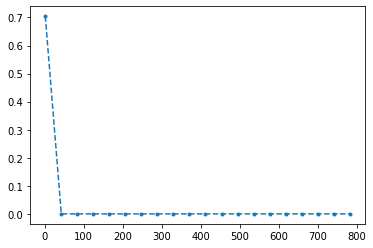

In [14]:
plt.plot(x_data, ZZ_result, '.--')

## XX data:

In [ ]:
def XX(stuff):
    data, x = stuff
    return np.real(JC_MPS_dict[data].correlation(Z_A+Z_B, 2,x))

#no XX data
for data in JC_MPS_dict:
    t1 = time.time()
    x_data = list(range(2,data[1],int(data[1]/20)+1))
    stuff_list = [[data, x] for x in x_data]
    
    XX_result = Parallel(n_jobs=-1)(delayed(XX)(stuff) for stuff in stuff_list)
    XX_data = {'data_dictionary': str([data[0], data[1]]), 'x_data': str(x_data), 'ZZ_data': str(ZZ_result)}
    XX_df = pd.DataFrame(XX_data, index=[0])
    XX_df.to_csv('XX.csv', mode='a', header=False, index = False)
    t2 = time.time()
    print(f'done with round of length {data[1]} and it took {t2-t1} seconds')

## When we want to retrieve the data from a csv we can do the following:

In [99]:
def get_list_values(column_value):
    return ast.literal_eval(str(column_value[0]))

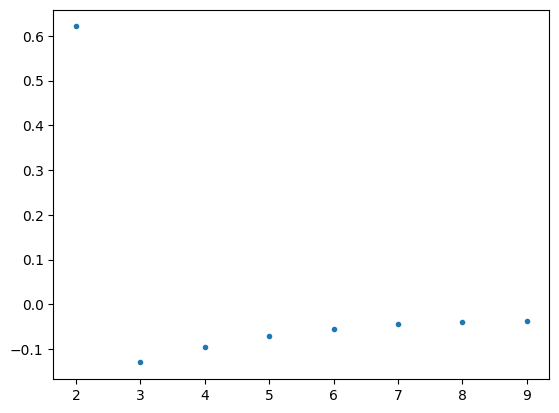

In [104]:
df = pd.read_csv('ZZ.csv', names=['dict', 'x_data', 'Z_data'],)

x_list = get_list_values(df[df['dict']=='[5.317361552716548, 10]']['x_data'])
ZZ_list = get_list_values(df[df['dict']=='[5.317361552716548, 10]']['Z_data'])

plt.plot(x_list,ZZ_list, '.')

# Now lets plot correlation functions for the MPS above

In [ ]:
# for JC
Z_A, Z_B = [np.kron(pauli('Z'), np.eye(2)), np.kron(np.eye(2),pauli('Z'))]
X_A, X_B = [np.kron(pauli('X'), np.eye(2)), np.kron(np.eye(2),pauli('X'))]

#for Motz
Zspin1 = pauli('Z', dim=3)
Xspin1 = pauli('X', dim=3)


## ZZ and XX correlation function matrix for each theta:

## Grid of XX and ZZ correlation functions 


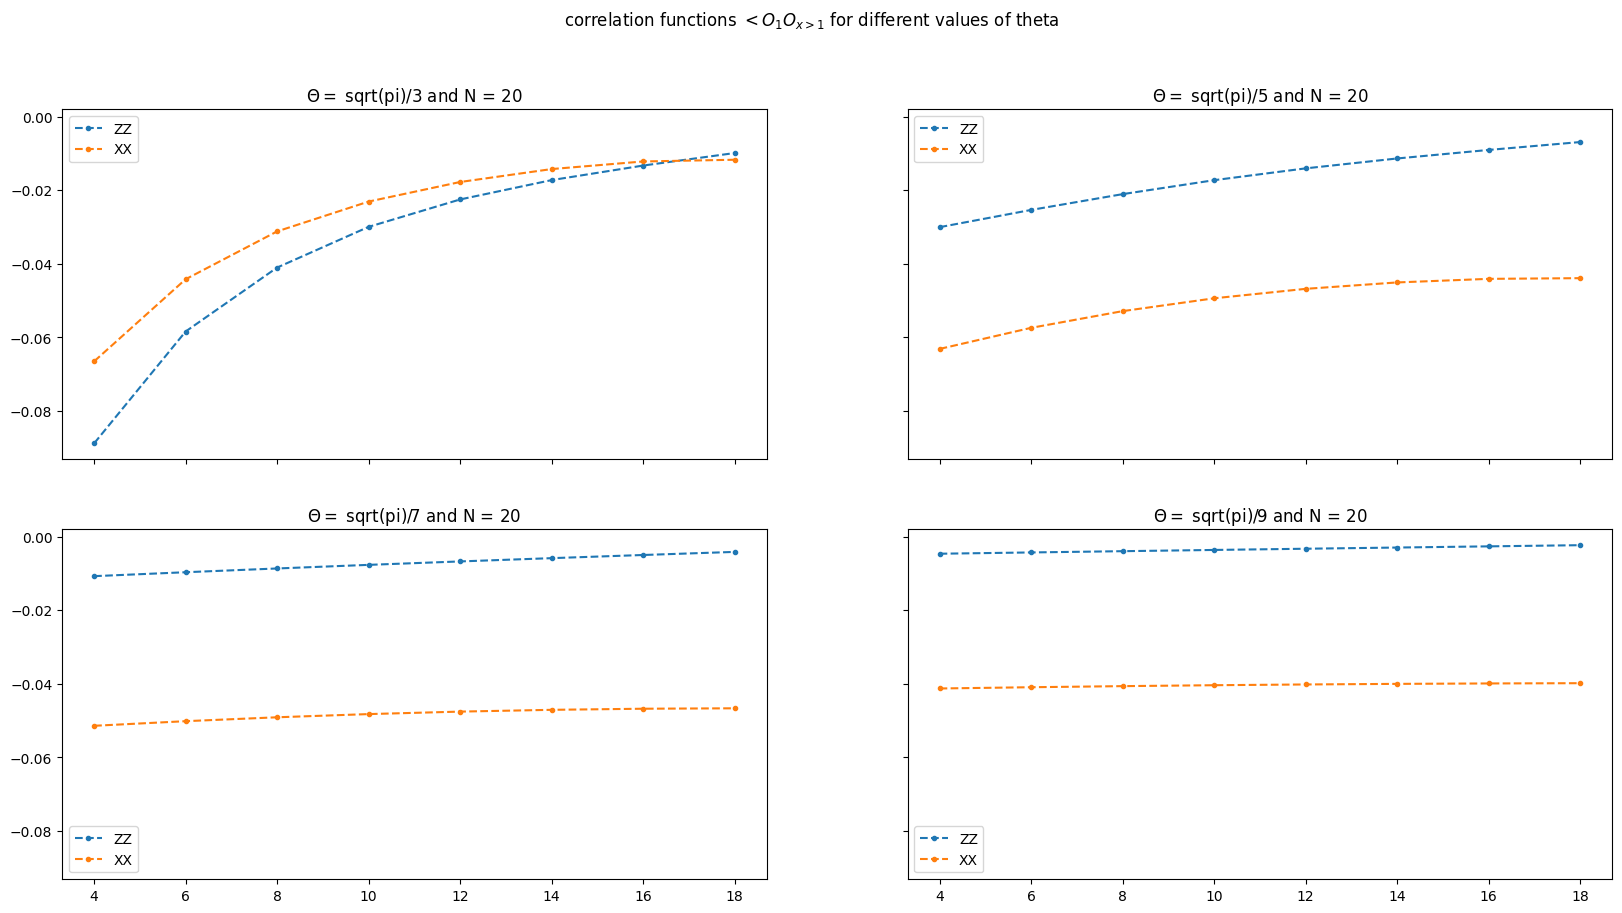

In [ ]:
n = 1
fig, axs = plt.subplots(2,2, figsize = (20,10), sharex=True, sharey=True)
for x in range(2):
    for y in range(2):
        x_data, Z_data, X_data = [ZZ_data_JC[theta_list[2*y+x], N_list[n]][0][1:],ZZ_data_JC[theta_list[2*y+x], N_list[n]][1][1:], XX_data_JC[theta_list[2*y+x], N_list[n]][1][1:]]
        
        axs[y,x].plot(x_data, Z_data, '.--', label = 'ZZ')
        axs[y,x].plot(x_data, X_data, '.--', label = 'XX')
        #axs[y,x].plot(ZZ_data_motz[1,2:], '.--', label = 'ZZ motz')
        #axs[y,x].plot(XX_data_motz[1,2:], '.--', label = 'XX motz')
        #axs[y,x].set_yscale('log')
        #axs[y,x].set_xscale('log')
        axs[y,x].set_title(f'$\Theta =$ {theta_sym_list[2*y+x]} and N = {N_list[n]}')
        axs[y,x].legend()


fig.suptitle('correlation functions $<O_1 O_{x>1}$ for different values of theta')
plt.show()

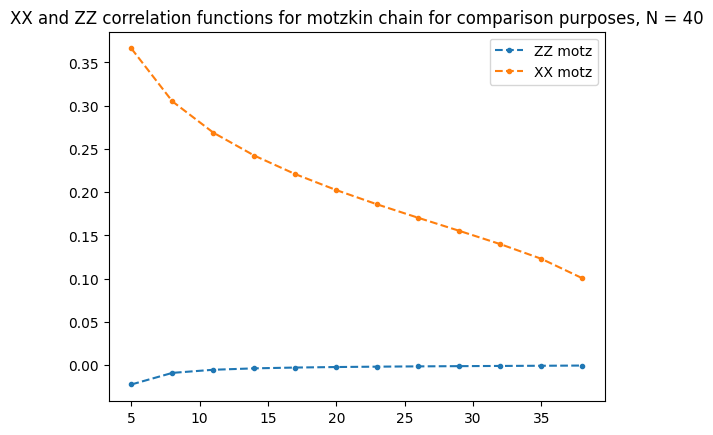

In [ ]:
n = 2
x_data, Z_data, X_data = [ZZ_data_motz[N_list[n]][0][1:],ZZ_data_motz[N_list[n]][1][1:], XX_data_motz[N_list[n]][1][1:]]

plt.plot(x_data,Z_data, '.--', label = 'ZZ motz')
plt.plot(x_data,X_data, '.--', label = 'XX motz')
plt.legend()
plt.title(f'XX and ZZ correlation functions for motzkin chain for comparison purposes, N = {N_list[n]}')
plt.show()

# $S_E$ array for each theta

t0 = time.time()
SE_data_JC = {}
SE_data_motz = {}
N_list = [10,30,100,200,400]

for N in N_list:
    x_list = list(range(2,N,int(N/15)+1))
    for theta in theta_list:
        SE_array = np.zeros(len(x_list))
        for i, x in enumerate(x_list):
            SE_array[i] = MPS_dictionary[theta, N].entropy(x)

        SE_data_JC[theta, N] = [x_list,SE_array]

    SE_motz = np.zeros(len(x_list))
    for i, x in enumerate(x_list):
            SE_motz[i] = MPS_Motz_dictionary[N].entropy(x)
    
    SE_data_motz[N] = [x_list,SE_motz]

    print(f'finished N = {N} at time {time.time()-t0}')

In [30]:
t0 = time.time()
SE_data_JC = {}
SE_data_motz = {}
N_list = [10,30,100,200,4000]

for N in N_list:
    x_data = list(range(2,N,int(N/20)+1))
    chi = max(int(np.sqrt(N)), 15)
    for theta in theta_list:
        M = M_JC(chi, theta)
        SE_data_JC[theta, N] = [x_data, [SE_fromM([M for i in range(N)], x) for x in x_data]]

    #Now motz data for comparison 
    M_motz = M_randwalk(chi, .2)
    SE_data_motz[N] = [x_data, [SE_fromM([M_motz for i in range(N)], x) for x in x_data]]
    
    print(f'done with N = {N} at time {time.time()-t0}')
    print('==================================')


done with N = 10 at time 0.0032036304473876953
done with N = 30 at time 0.012127876281738281
done with N = 100 at time 0.0349879264831543
done with N = 200 at time 0.0772249698638916
done with N = 4000 at time 11.491073608398438


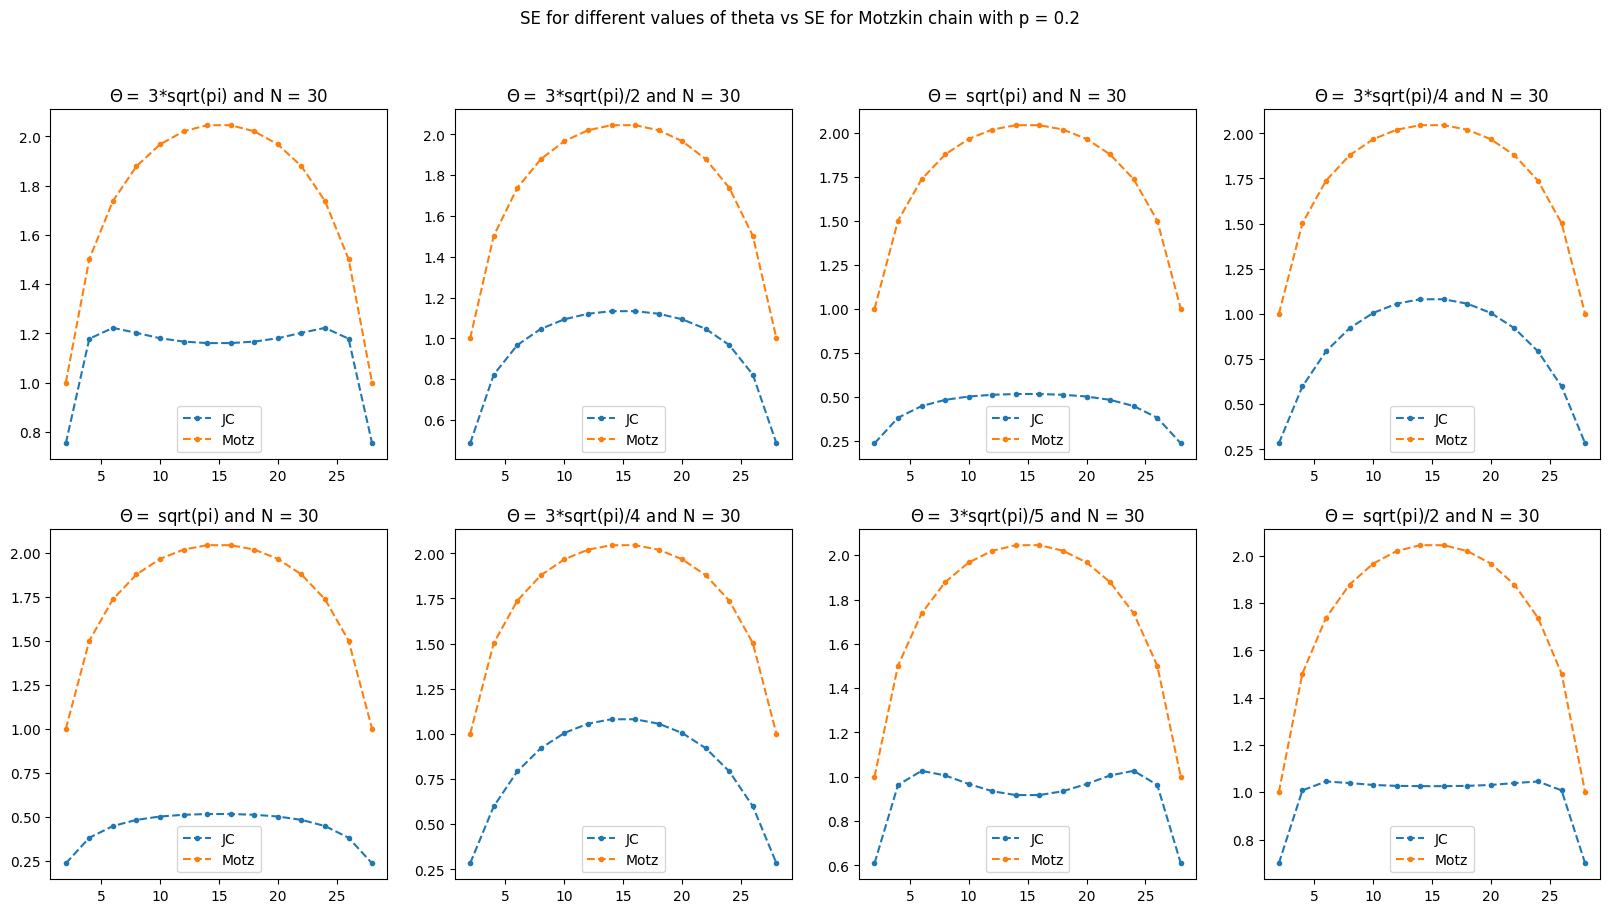

In [31]:
n=1
fig, axs = plt.subplots(2,4, figsize = (20,10))
for x in range(4):
    for y in range(2):
        x_list, SJC, SMotz = [SE_data_JC[theta_list[4*y+x], N_list[n]][0],SE_data_JC[theta_list[2*y+x], N_list[n]][1], SE_data_motz[N_list[n]][1]]

        axs[y,x].plot(x_list,SJC, '.--', label = 'JC')
        axs[y,x].plot(x_list,SMotz, '.--', label = 'Motz')
        axs[y,x].set_title(f'$\Theta =$ {theta_sym_list[2*y+x]} and N = {N_list[n]}')
        axs[y,x].legend()


fig.suptitle(f'SE for different values of theta vs SE for Motzkin chain with p = {pL}')
plt.show()

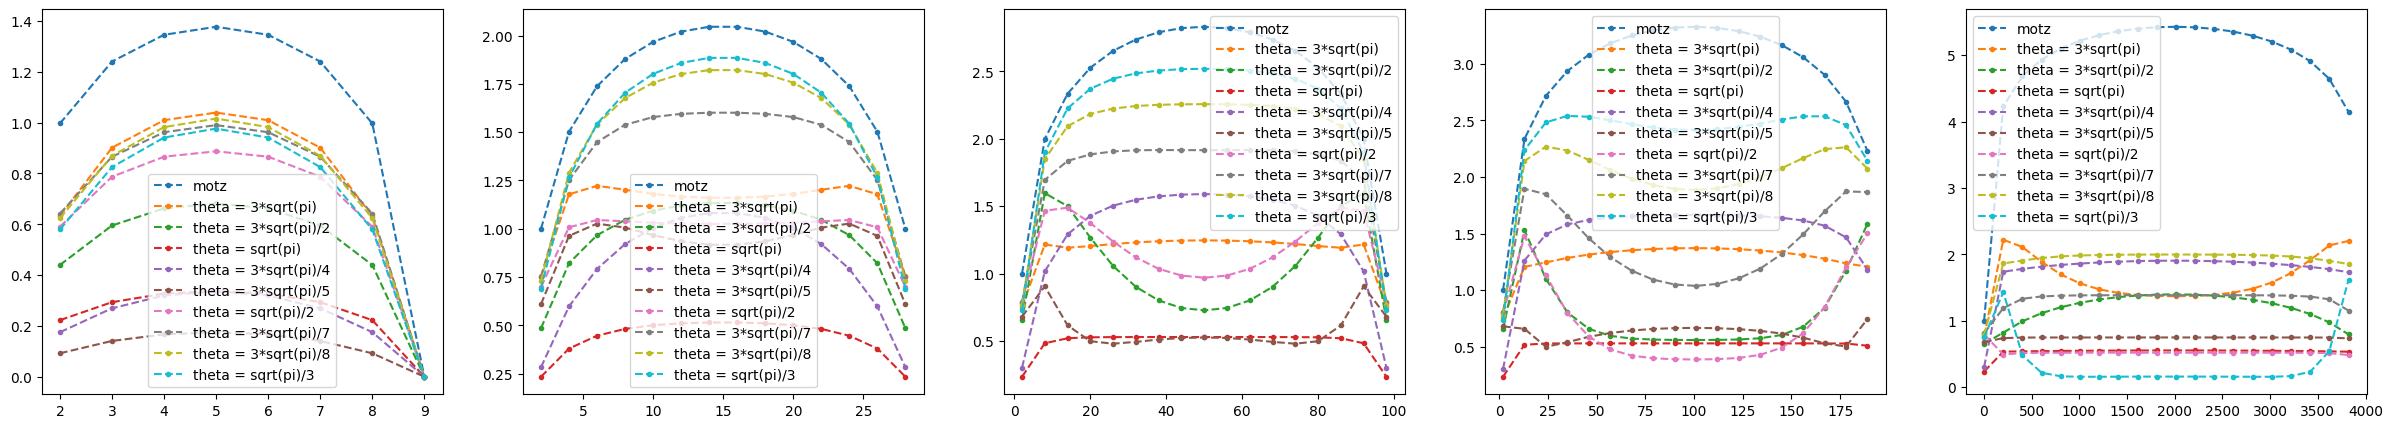

In [36]:
fig, axs = plt.subplots(1,len(N_list), figsize = (30,5))

for i,N in enumerate(N_list):
    axs[i].plot(SE_data_motz[N][0], SE_data_motz[N][1], '--.', label = f'motz')
    
    for j,theta in enumerate(theta_list):
        axs[i].plot(SE_data_JC[theta,N][0], SE_data_JC[theta,N][1], '--.', label = f'theta = {theta_sym_list[j]}')

    axs[i].legend()